In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats import boxcox
from tqdm.notebook import tqdm

In [3]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader
import os
from surprise import accuracy
import numpy as np
from surprise.model_selection import RandomizedSearchCV
from surprise.model_selection import GridSearchCV


In [4]:
plt.rcParams['figure.figsize'] = (15, 8)

In [5]:
base_db = pd.read_csv("../output/base_db.csv").drop(columns="Unnamed: 0")

# Matrix factorization

In [6]:
# function to compute RMSE (needs correct matrices)
def compute_rmse(X_real, X_predict, pred_target = "score"):
    # total rmse on seen data
    dim = X_real.index.size
    s = 0
    for _, row in X_real.iterrows():
        s+=0.5*(row[pred_target] - X_predict[int(row.test_cas), int(row.species)])**2
    rmse = np.sqrt(s/dim)
    return rmse

In [101]:
def compute_absolute_intervals(X_real, X_pred_conc, pred_target="conc1_mean"):
    X_intervals = X_real.copy()
    intervals = np.zeros(X_intervals.index.size)
    prediction = np.zeros(X_intervals.index.size)
    
    for i, row in X_intervals.iterrows():
        prediction[i] =  X_pred_conc[int(row.test_cas), int(row.species)]
        intervals[i] = np.abs(row[pred_target] - prediction[i])
        
    X_intervals["prediction"] = prediction   
    X_intervals["intervals"] = intervals
    return X_intervals

# CONSIDERING ONLY 96 H

In [122]:
X_original = base_db.copy()
X_original = X_original[["test_cas", "species", "conc1_mean", "obs_duration_mean"]]

In [123]:
X_original = X_original[X_original.obs_duration_mean==96]

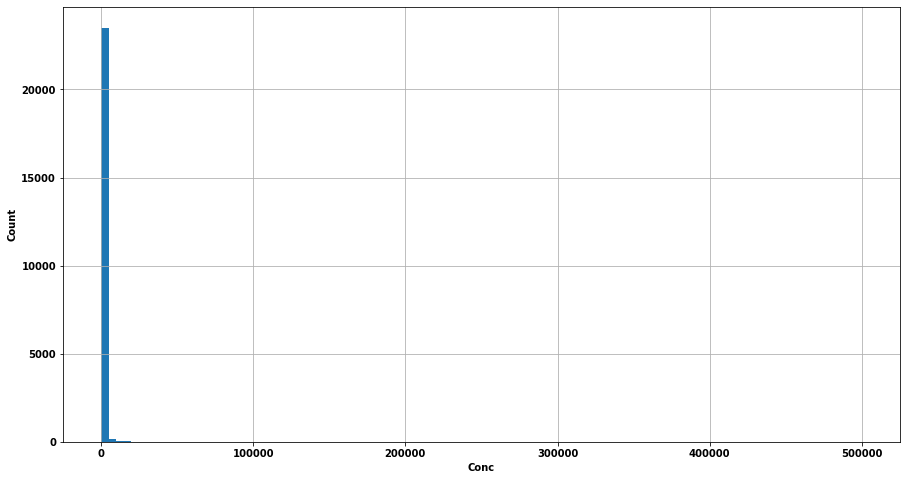

In [124]:
# plotting the distribution of conc inside this case
X_original.conc1_mean.hist(bins=100)
#plt.yscale('log')
plt.xlabel("Conc")
plt.ylabel("Count");

In [125]:
# # applying coxbox transformation to reduce skewness
# X_fact.conc1_mean, lambda_ = boxcox(X_fact.conc1_mean)
# X_fact.conc1_mean.hist(bins=100)
# #plt.yscale('log')
# plt.xlabel("Conc")
# plt.ylabel("Count");

In [126]:
# function to come back from coxbox
#te = np.exp(np.log(lambda_ * X_fact.conc1_mean + 1) / lambda_)

In [127]:
X_original = X_original.groupby(by=["test_cas", "species"]).agg("median").reset_index()

In [128]:
X_original["score"] = 1/X_original.conc1_mean

In [129]:
enc = OrdinalEncoder(dtype=int)
enc.fit(X_original[["test_cas", "species"]])
X_original[["test_cas", "species"]] = enc.transform(X_original[["test_cas", "species"]])
X_fact = X_original.drop(columns=["conc1_mean", "obs_duration_mean"]).reset_index(drop=True)

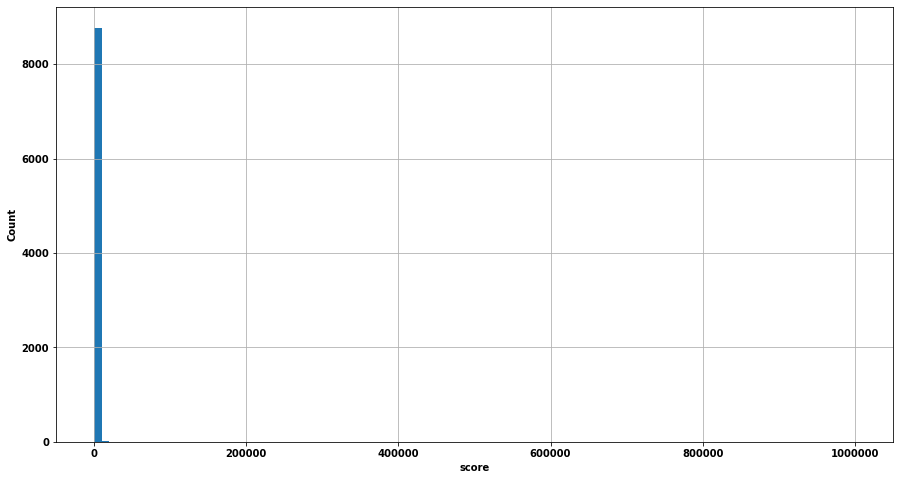

In [130]:
# plotting the distribution of conc inside this case
X_fact.score.hist(bins=100)
#plt.yscale('log')
plt.xlabel("score")
plt.ylabel("Count");

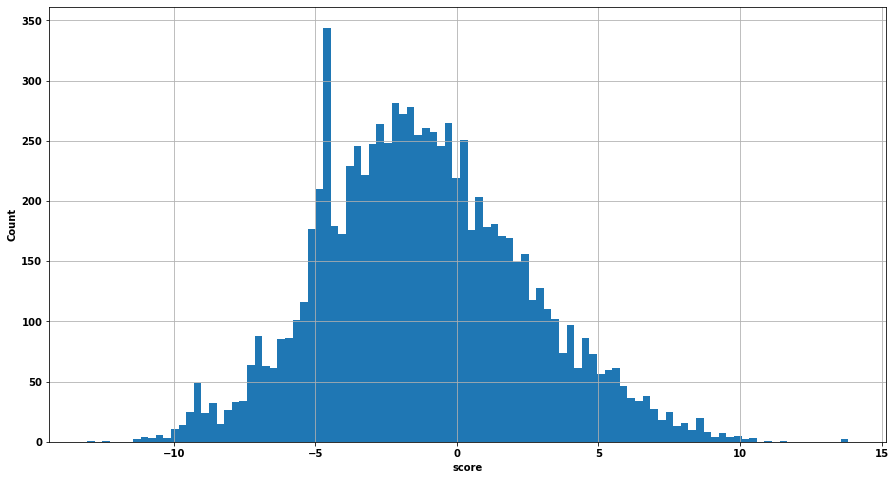

In [131]:
X_fact_scored = X_fact.copy()
X_fact_scored.score = X_fact_scored.score.apply(lambda x: np.log(x))
# plotting the distribution of conc inside this case
X_fact_scored.score.hist(bins=100)
#plt.yscale('log')
plt.xlabel("score")
plt.ylabel("Count");

In [132]:
X_train_original, X_test_original, X_train_scored, X_test_scored = train_test_split(X_original, X_fact_scored, test_size=0.33)

In [133]:
X_train_original = X_train_original.reset_index(drop=True)
X_test_original = X_test_original.reset_index(drop=True)
X_train_scored = X_train_scored.reset_index(drop=True)
X_test_scored = X_test_scored.reset_index(drop=True)

## Implementing CV for choosing MinMaxRange
- Split in 5 folds using sklearn
- Using built-in surprise CV to select best params
- Compute RMSE over test set (RMSE over transformed matrix -> dealing again with concentrations)
- Average RMSEs
- Best RMSE: save it

In [136]:
def cv_factorization(X_real, X_real_scored, min_scale = 10, max_scale = 50, step_size=10, cv = 3):
    best_scale = 0
    best_rmse = np.inf
    best_surprise = []
    cas = X_real.test_cas.max()
    species = X_real.species.max()
    
    for scale in tqdm(range(min_scale, max_scale+1, step_size)):
        
        X_real_score = X_real_scored.copy()

        # MinMax scale score
        minmax = MinMaxScaler((1, scale))
        minmax.fit(X_real_score[["score"]])
        X_real_score[["score"]] = minmax.transform(X_real_score[["score"]])
        
        kf = KFold(n_splits=cv, shuffle=True)
        
        rmses = []
        params = []
        
        for train_index, test_index in kf.split(X_real_score):
        
            X_real_score.loc[train_index].to_csv("../output/score_matrix_cv.csv", header=True, index=False)
    

            # surprise
            file_path = os.path.expanduser("../output/score_matrix_cv.csv")
            reader = Reader(sep=",", skip_lines=1, rating_scale=(1, scale))
            data = Dataset.load_from_file(file_path, reader)

            param_grid = {'lr_all': np.logspace(-4, 0, 20),
                  'reg_all': np.logspace(-4, 0, 20),
                  'n_factors': range(1, 1001)}

            gs = RandomizedSearchCV(SVD, param_grid, n_iter = 20, measures=['rmse'], cv=3, n_jobs = -2, joblib_verbose=0, refit=True)
            #gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -4, joblib_verbose=0, refit=True)
            gs.fit(data)
            
            params.append(gs.best_params)
            
            # predict both on train and test
            X_predict = np.zeros((cas+1, species+1))
            for d in range(0, cas+1):
                for n in range(0, species+1):
                    X_predict[d,n] = gs.predict(str(d),str(n))[3]
            
            
            # coming back from minmax, log and 1/conc and measure new rmse
            X_predict = minmax.inverse_transform(X_predict)
            X_predict = np.exp(X_predict)    
            X_predict = 1/X_predict
            
            # rmse
            X_real_conc_test = X_real.loc[test_index].copy()
            rmse = compute_rmse(X_real_conc_test, X_predict, "conc1_mean")
            
            rmses.append(rmse)
        
        avg_rmse = np.mean(rmses)
        print("Scale: {}, avg_rmse: {}".format(scale, avg_rmse))
        if (avg_rmse < best_rmse):
            print("New best scale found:", scale)
            print("New best rmse", avg_rmse)
            best_rmse = avg_rmse
            best_scale = scale
            best_surprise = params
    
    return best_rmse, best_scale, best_surprise

In [ ]:
best_rmse, best_scale, best_surprise = cv_factorization(X_train_original, X_train_scored, min_scale=10, max_scale=400, step_size=20, cv=3)

## Best params up to now

In [89]:
params = {'lr_all': 0.0038397146471078284, 'reg_all': 0.0029012887277528286, 'n_factors': 348}
best_scale = 190

In [52]:
params = {'lr_all':sum(d['mae']['lr_all'] for d in best_surprise) / len(best_surprise), \
          'reg_all':sum(d['mae']['reg_all'] for d in best_surprise) / len(best_surprise), \
          'n_factors':int(sum(d['mae']['n_factors'] for d in best_surprise) / len(best_surprise))}

**Test on previous defined test set**

In [90]:
fact = SVD(n_factors = params["n_factors"], lr_all = params["lr_all"], reg_all=params["reg_all"])
minmax = MinMaxScaler((1, best_scale))
minmax.fit(X_train_scored[["score"]])
X_train_scored["score_scaled"] = minmax.transform(X_train_scored[["score"]])

In [91]:
cas = X_test_original.test_cas.max()
species = X_test_original.species.max()

X_train_scored[["test_cas", "species", "score_scaled"]].to_csv("../output/score_matrix_best_full.csv", header=True, index=False)

# surprise
file_path = os.path.expanduser("../output/score_matrix_best_full.csv")
reader = Reader(sep=",", skip_lines=1, rating_scale=(1, best_scale))
data = Dataset.load_from_file(file_path, reader)

train = data.build_full_trainset()
fact.fit(train)

# predict both on train and test
X_predict = np.zeros((cas+1, species+1))
for d in range(0, cas+1):
    for n in range(0, species+1):
        X_predict[d,n] = fact.predict(str(d),str(n))[3]

In [92]:
minmax = MinMaxScaler((1, best_scale))
minmax.fit(X_test_scored[["score"]])
X_test_scored["score_scaled"] = minmax.transform(X_test_scored[["score"]])
compute_rmse(X_test_scored, X_predict, "score_scaled")

15.22708130741492

In [93]:
 # coming back from minmax, log and 1/conc and measure new rmse
X_predict2 = minmax.inverse_transform(X_predict)
X_predict2 = np.exp(X_predict2)    
X_predict2 = 1/X_predict2

# rmse
compute_rmse(X_test_original, X_predict2, "conc1_mean")

6312.2859943577105

In [94]:
X_test_original

,test_cas,species,conc1_mean,obs_duration_mean,score
0,2098,209,0.00271,96.0,369.003690
1,643,268,0.05525,96.0,18.099548
2,2569,220,5.17000,96.0,0.193424
3,2104,267,0.00091,96.0,1098.901099
4,294,260,10.80000,96.0,0.092593
...,...,...,...,...,...
2899,2433,404,0.99500,96.0,1.005025
2900,844,72,0.43000,96.0,2.325581
2901,2379,76,0.72000,96.0,1.388889
2902,947,319,32.90000,96.0,0.030395


In [103]:
X_intervals = compute_absolute_intervals(X_test_original, X_predict2)
X_intervals

,test_cas,species,conc1_mean,obs_duration_mean,score,prediction,intervals
0,2098,209,0.00271,96.0,369.003690,0.623965,0.621255
1,643,268,0.05525,96.0,18.099548,0.774358,0.719108
2,2569,220,5.17000,96.0,0.193424,8.182275,3.012275
3,2104,267,0.00091,96.0,1098.901099,0.014911,0.014001
4,294,260,10.80000,96.0,0.092593,21.253481,10.453481
...,...,...,...,...,...,...,...
2899,2433,404,0.99500,96.0,1.005025,5.656168,4.661168
2900,844,72,0.43000,96.0,2.325581,3.629338,3.199338
2901,2379,76,0.72000,96.0,1.388889,6.064778,5.344778
2902,947,319,32.90000,96.0,0.030395,151.006365,118.106365


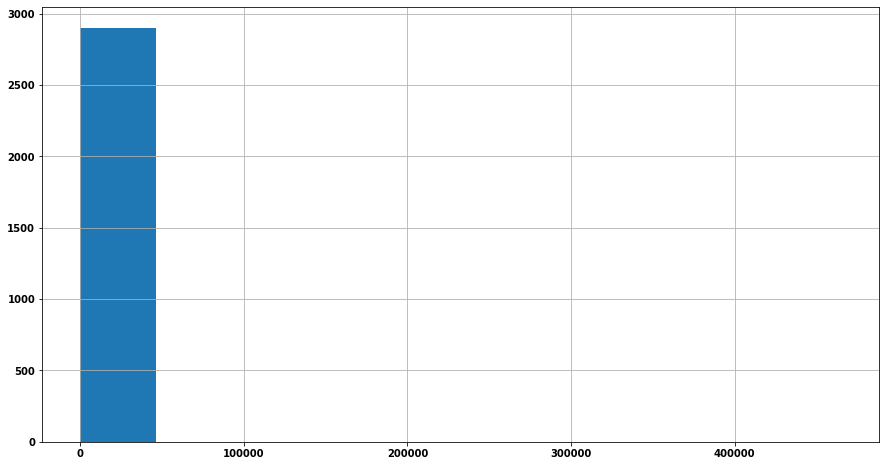

In [106]:
X_intervals.intervals.hist()

## Using all data as test set

In [108]:
fact = SVD(n_factors = params["n_factors"], lr_all = params["lr_all"], reg_all=params["reg_all"])
minmax = MinMaxScaler((1, best_scale))
minmax.fit(X_fact_scored[["score"]])
X_fact_scored["score_scaled"] = minmax.transform(X_fact_scored[["score"]])

In [109]:
cas = X_fact_scored.test_cas.max()
species = X_fact_scored.species.max()

X_fact_scored[["test_cas", "species", "score_scaled"]].to_csv("../output/score_matrix_best_full.csv", header=True, index=False)

# surprise
file_path = os.path.expanduser("../output/score_matrix_best_full.csv")
reader = Reader(sep=",", skip_lines=1, rating_scale=(1, best_scale))
data = Dataset.load_from_file(file_path, reader)

train = data.build_full_trainset()
fact.fit(train)

# predict both on train and test
X_predict = np.zeros((cas+1, species+1))
for d in range(0, cas+1):
    for n in range(0, species+1):
        X_predict[d,n] = fact.predict(str(d),str(n))[3]

In [110]:
compute_rmse(X_fact_scored, X_predict, "score_scaled")

0.3950465366643398

In [111]:
X_fact_scored

,test_cas,species,score,score_scaled
0,0,3,-4.877485,58.492974
1,0,71,-4.271095,62.758985
2,0,82,-5.446737,54.488228
3,0,131,-4.744932,59.425495
4,0,167,-4.644391,60.132812
...,...,...,...,...
8795,2577,330,7.392264,144.811838
8796,2578,330,6.794427,140.605997
8797,2579,330,6.412449,137.918751
8798,2580,331,3.846704,119.868481


In [112]:
 # coming back from minmax, log and 1/conc and measure new rmse
X_predict2 = minmax.inverse_transform(X_predict)
X_predict2 = np.exp(X_predict2)    
X_predict2 = 1/X_predict2

# rmse
rmse = compute_rmse(X_original, X_predict2, "conc1_mean")

In [113]:
rmse

780.0829528618531

In [114]:
X_original

,test_cas,species,conc1_mean,obs_duration_mean,score
0,0,3,131.300000,96.0,0.007616
1,0,71,71.600000,96.0,0.013966
2,0,82,232.000000,96.0,0.004310
3,0,131,115.000000,96.0,0.008696
4,0,167,104.000000,96.0,0.009615
...,...,...,...,...,...
8795,2577,330,0.000616,96.0,1623.376623
8796,2578,330,0.001120,96.0,892.857143
8797,2579,330,0.001641,96.0,609.384522
8798,2580,331,0.021350,96.0,46.838407


In [115]:
X_intervals = compute_absolute_intervals(X_original, X_predict2)

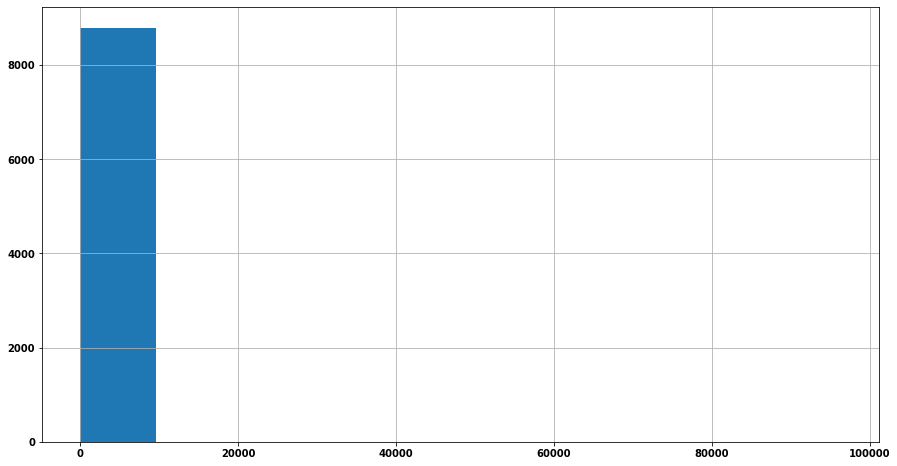

In [116]:
X_intervals.intervals.hist()

In [117]:
X_intervals[X_intervals.intervals > 10000]

,test_cas,species,conc1_mean,obs_duration_mean,score,prediction,intervals
5098,1494,220,9000.0,96.0,0.000111,20241.432557,11241.432557
5180,1499,220,12946.0,96.0,0.000077,33246.268393,20300.268393
5388,1527,220,12750.0,96.0,0.000078,25304.988408,12554.988408
5893,1594,220,250050.0,96.0,0.000004,346362.881627,96312.881627


RMSE without that single big component

In [118]:
compute_rmse(X_original[(X_original.test_cas!=1594) & (X_original.species!=220)], X_predict2, "conc1_mean")

146.70102169693433